# Prediction of Synaptic Clusters in Inhibitory Neurons  
### *Supervised learning using K-Nearest Neighbors, Random Forest, and XGBoost*

## I. Introduction

* The aim of this project is to train supervised machine learning models to predict the cluster membership of newly observed synapses belonging to inhibitory neurons.

* The models are trained using the clustering results obtained in a previous project, where historical synapse data were analyzed using an unsupervised UMAP–HDBSCAN approach. These previously identified clusters serve as labels for supervised learning.

* Several supervised learning algorithms were evaluated to determine which models provide the most reliable predictions across different synapse types and neuronal subgroups.

## II. Objectives

* To compare the performance of different supervised models across distinct investigation groups.  K-Nearest Neighbors (KNN) and tree-based models (Random Forest and XGBoost) were evaluated using features derived from the former UMAP–HDBSCAN clustering pipeline.

* To predict the cluster assignment of newly observed synapses using the best-performing trained models.

## III. Methodology

* <u>Exploratory Data Analysis (EDA)</u>  
   Statistical and visual exploration of the UMAP-transformed synapse data and cluster distributions.

* <u>Supervised Model Training</u>  
   Supervised learning models were trained using UMAP_1, UMAP_2, and cluster labels as input features.  
   The following models were evaluated:
   - K-Nearest Neighbors (KNN)
   - Random Forest
   - XGBoost  

   Models were trained separately for each synapse and neuron group:
   - Excitatory synapses (asymmetric, *as*)
   - Inhibitory synapses (symmetric, *ss*)
   - Calbindin (*cb*)
   - Calretinin (*cr*)
   - Parvalbumin (*pv*)

* <u>Prediction of New Synapses</u>  
   The trained models were applied to predict cluster membership for newly observed synapses  
   to illustrate the prediction workflow (10 synapses per NeuronType).

## IV. Model Performance Evaluation

### IV.1.1 About the dataset

| Variable   | Description |
|------------|-------------|
| SynId      | Unique synapse identifier (synapse number) |
| NeuronType | Type of inhibitory neuron (calbindin, calretinin, parvalbumin) |
| NeuronId   | Abbreviation of calcium-binding inhibitory neurons (cb – calbindin; cr – calretinin; pv – parvalbumin) combined with the neuron index (3 neurons per type) |
| SynType    | Abbreviation of synapse types (as – asymmetric excitatory synapse; ss – symmetric inhibitory synapse) |
| UMAP_1     | First dimension of the UMAP embedding representing a low-dimensional projection of synaptic features |
| UMAP_2     | Second dimension of the UMAP embedding representing a low-dimensional projection of synaptic features |
| Cluster    | Assigned cluster label of the synapse based on spatial density-based clustering |
| clusterid  | Clustering group identifier used to distinguish different clustering strategies ('as', 'ss', 'cb', 'cr', 'pv') |
                

### IV.1.2 Import the recquired libraries

In [99]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

sys.path.append(os.path.abspath('src'))
from train import split_umap_data, knn_with_outlier_filtering, plot_confusion_matrix, random_forest_with_outlier_filtering, xgboost_with_outlier_filtering, xgboost_plot_confusion_matrix

In [46]:
import importlib
import train  
importlib.reload(train)

from train import split_umap_data, knn_with_outlier_filtering, plot_confusion_matrix, random_forest_with_outlier_filtering, xgboost_with_outlier_filtering, xgboost_plot_confusion_matrix


### IV.1.3 Data loading

Load CSV dataset (result of neuron_synapse_clustering_part1.ipynb project)

In [100]:
df_neuron_cluster = pd.read_csv('neuron_synapse_clustering_HDBSCAN_result.csv')
df_neuron_cluster.head()

,SynId,NeuronType,NeuronId,SynType,UMAP_1,UMAP_2,Cluster,clusterid
0,1,calbindin,cb1,as,-0.830409,8.352609,3,as
1,2,calbindin,cb1,as,-1.162567,8.336290,3,as
2,3,calbindin,cb1,as,-1.097508,8.339774,3,as
3,6,calbindin,cb1,as,-0.703955,8.379145,3,as
4,9,calbindin,cb1,as,-0.486376,8.493205,3,as


Display the data types

In [101]:
df_neuron_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1496 entries, 0 to 1495
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SynId       1496 non-null   int64  
 1   NeuronType  1496 non-null   object 
 2   NeuronId    1496 non-null   object 
 3   SynType     1496 non-null   object 
 4   UMAP_1      1496 non-null   float64
 5   UMAP_2      1496 non-null   float64
 6   Cluster     1496 non-null   int64  
 7   clusterid   1496 non-null   object 
dtypes: float64(2), int64(2), object(4)
memory usage: 93.6+ KB


### IV.1.4 Exploratory data analysis

**Descriptive Statistic**

In [102]:
df_neuron_cluster.describe()

,SynId,UMAP_1,UMAP_2,Cluster
count,1496.000000,1496.000000,1496.000000,1496.000000
mean,59.953209,4.904775,4.610963,2.153075
std,58.225319,6.617609,4.302845,1.124357
min,1.000000,-6.423135,-8.005506,-1.000000
25%,15.000000,0.002751,1.878099,2.000000
50%,35.500000,4.614501,5.750542,2.000000
75%,94.000000,9.437225,8.146004,3.000000
max,225.000000,23.663755,11.135642,5.000000


**Frequency Distribution of UMAP dimensions**

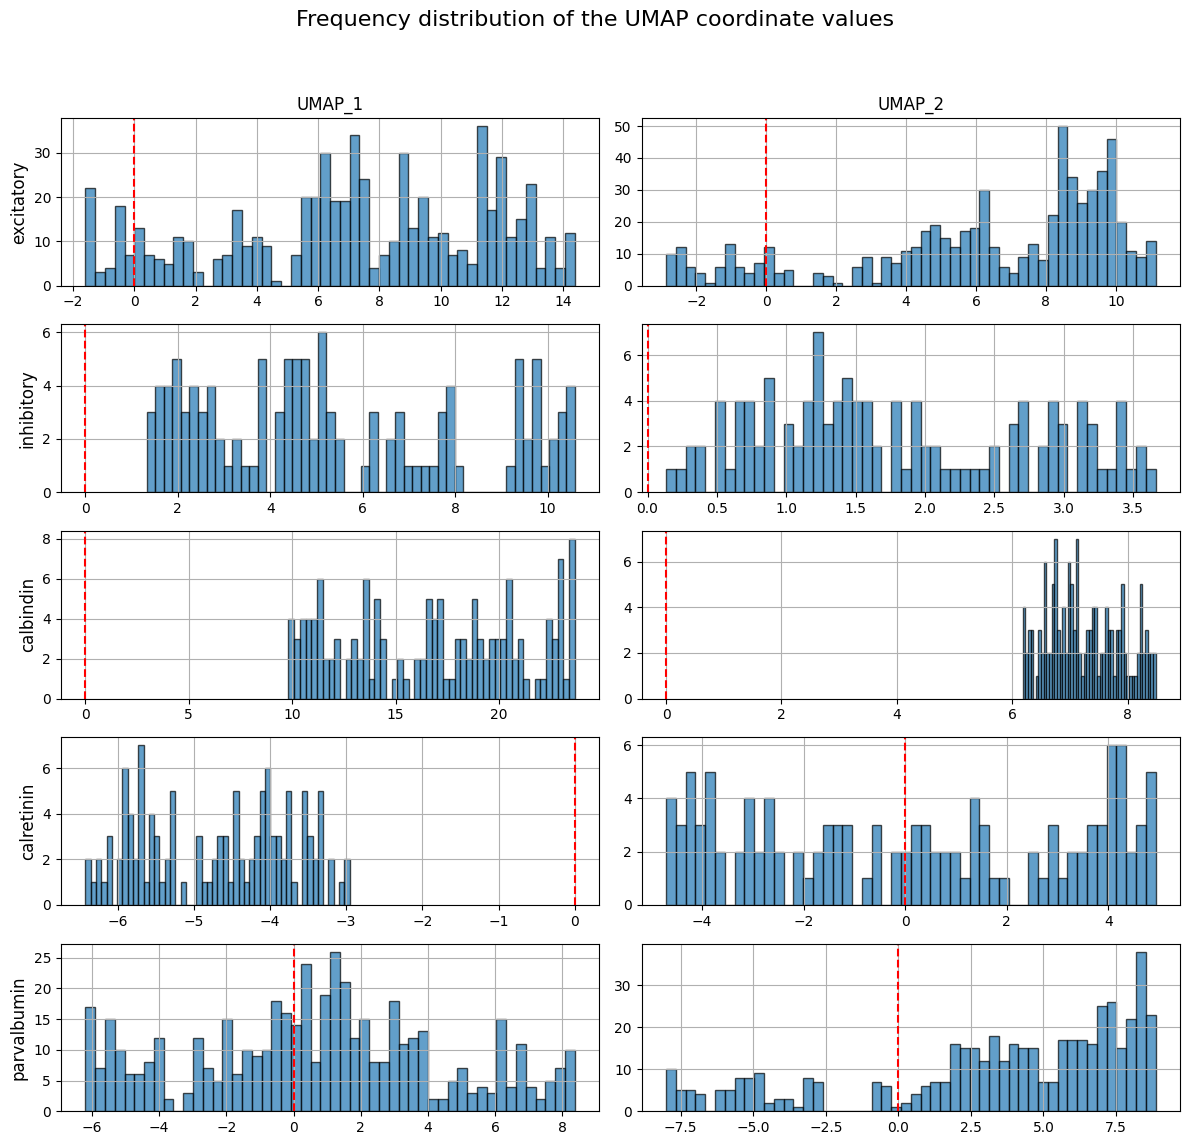

In [103]:
# Designate labels
cluster_labels = {
    'as': 'excitatory',
    'ss': 'inhibitory',
    'cb': 'calbindin',
    'cr': 'calretinin',
    'pv': 'parvalbumin'
}

columns_to_plot = ['UMAP_1', 'UMAP_2']
n_rows = len(cluster_labels)
fig, axes = plt.subplots(n_rows, 2, figsize=(12, 12), sharex=False)

# 2. Plot for all clusterids
for row_idx, (clusterid, label) in enumerate(cluster_labels.items()):
    df_sub = df_neuron_cluster[df_neuron_cluster['clusterid'] == clusterid]
    
    for col_idx, col in enumerate(columns_to_plot):
        ax = axes[row_idx, col_idx]
        df_sub[col].hist(ax=ax, bins=50, edgecolor='black', alpha=0.7)
        ax.axvline(0, color='red', linestyle='--', linewidth=1.5)
        
        # Titles
        if row_idx == 0:
            ax.set_title(f'{col}', fontsize=12)
        if col_idx == 0:
            ax.set_ylabel(label, fontsize=12)

fig.suptitle('Frequency distribution of the UMAP coordinate values', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


**Correlation Analysis**

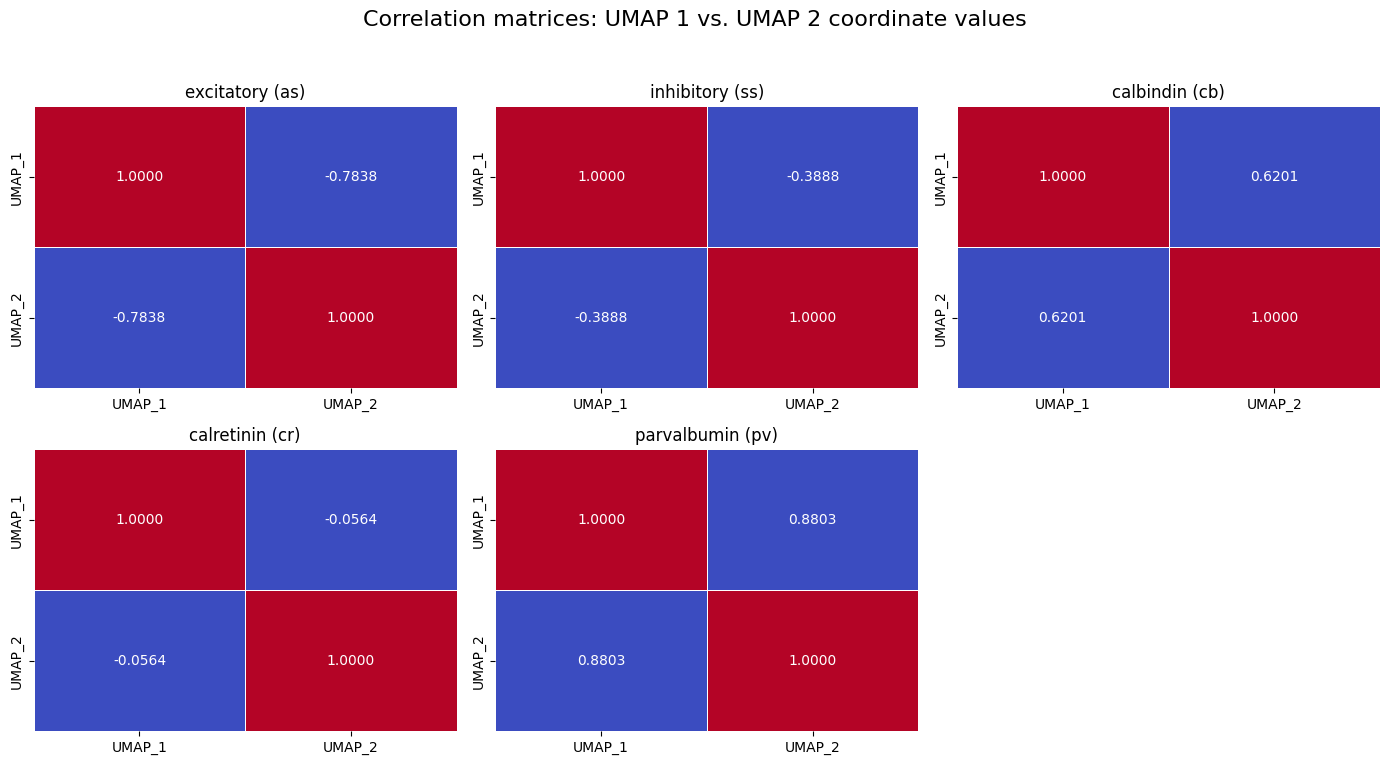

In [104]:
cluster_labels = {
    'as': 'excitatory',
    'ss': 'inhibitory',
    'cb': 'calbindin',
    'cr': 'calretinin',
    'pv': 'parvalbumin'
}

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, (clusterid, label) in enumerate(cluster_labels.items()):
    df_sub = df_neuron_cluster[df_neuron_cluster['clusterid'] == clusterid]
    corr = df_sub[['UMAP_1', 'UMAP_2']].corr()

    sns.heatmap(
        corr,
        annot=True,
        cmap='coolwarm',
        fmt='.4f',
        linewidths=0.5,
        cbar=False,
        ax=axes[i]
    )
    axes[i].set_title(f'{label} ({clusterid})')

for j in range(len(cluster_labels), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Correlation matrices: UMAP 1 vs. UMAP 2 coordinate values', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Correlation was not revealed between UMAP_1 and UMAP_2.

### IV.1.5 Testing supervised models

#### IV.1.5.1 **Excitatory ('as') synapses**

In [105]:
as_train = df_neuron_cluster[df_neuron_cluster['clusterid'] == 'as']

In [106]:
as_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 631 entries, 0 to 630
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SynId       631 non-null    int64  
 1   NeuronType  631 non-null    object 
 2   NeuronId    631 non-null    object 
 3   SynType     631 non-null    object 
 4   UMAP_1      631 non-null    float64
 5   UMAP_2      631 non-null    float64
 6   Cluster     631 non-null    int64  
 7   clusterid   631 non-null    object 
dtypes: float64(2), int64(2), object(4)
memory usage: 44.4+ KB


**K-Nearest Neighbors (KNN)**

Short explanation of the definition used below (see train.py):

*Outlier detection (One-Class SVM)*
A One-Class SVM is trained on the scaled training data to identify out-of-distribution synapses, which are excluded from standard KNN classification.

*Hyperparameter tuning (GridSearchCV)*
The optimal number of neighbors and distance metric for the KNN model are selected using cross-validation and micro-averaged F1 score.

*Final prediction and evaluation*
The tuned KNN model assigns cluster labels to inlier synapses, while outliers are flagged separately, and performance is evaluated using standard classification metrics.

In [107]:
as_data = split_umap_data(as_train)
y_test_as = as_data['y_as_test']
as_knn_result = knn_with_outlier_filtering(
    as_data,
    label='as',
    nu=0.03,
    k_range=(1, 30, 2),
    cv=5
)

Optimal K: 1, Metric: euclidean

Classification Report:
              precision    recall  f1-score   support

          -1       0.21      0.60      0.32         5
           1       1.00      0.83      0.91        18
           2       1.00      0.87      0.93        45
           3       0.97      0.94      0.96        34
           4       0.96      1.00      0.98        25

    accuracy                           0.90       127
   macro avg       0.83      0.85      0.82       127
weighted avg       0.95      0.90      0.92       127

Accuracy: 0.8976
Macro F1: 0.8178


**Random Forest**

Short explanation of the definition used below (see train.py)

*Outlier detection and filtering (One-Class SVM)* A One-Class SVM is trained on the scaled training data to identify inlier synapses, which are retained for model training, while outliers are excluded.

*Model training* A Random Forest classifier is trained only on the filtered inlier data to improve robustness against noisy or atypical observations.

*Prediction and evaluation* Test samples identified as outliers are flagged separately, while inliers are classified using the trained model and evaluated with standard performance metrics.

In [108]:
as_rf_result = random_forest_with_outlier_filtering(
    data_dict=as_data,    
    label='as',           # clusterid
    nu=0.05,              # 5% outlier — covers well 4.2%
    n_estimators=100,     # stable, recommended value according to the value count
    max_depth=10          # limited depth, to avoid overfitting
)


Classification Report:
              precision    recall  f1-score   support

          -1       0.16      0.60      0.25         5
           1       1.00      0.72      0.84        18
           2       1.00      0.84      0.92        45
           3       0.97      0.94      0.96        34
           4       0.96      0.92      0.94        25

    accuracy                           0.86       127
   macro avg       0.82      0.81      0.78       127
weighted avg       0.95      0.86      0.89       127

Accuracy: 0.8583
Macro F1: 0.7797


**XGBoost**

Short explanation of definition used below (see train.py)

*Outlier detection and data cleaning (One-Class SVM)* A One-Class SVM is applied to the training and test sets to detect outliers, and only inlier synapses are retained for model training and evaluation.

*Label encoding and model training (XGBoost)* Class labels are encoded numerically, and an XGBoost classifier is trained on the filtered inlier data to perform multi-class cluster prediction.

*Prediction and evaluation* Predictions are generated for inlier test samples, converted back to original labels, and evaluated using accuracy and macro F1-score metrics.

In [109]:
as_xgboost_result = xgboost_with_outlier_filtering(
    data_dict=as_data,
    label='as',
    nu=0.05,
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=42
)

y_pred_as = as_xgboost_result["y_pred"]
y_test_clean_as = as_xgboost_result["y_test_clean"]


XGBoost + OneClassSVM results (only Inliers):
Accuracy: 0.9569
Macro F1: 0.9104
              precision    recall  f1-score   support

          -1       0.75      0.60      0.67         5
           1       1.00      1.00      1.00        13
           2       0.95      0.98      0.96        42
           3       0.97      1.00      0.98        32
           4       0.96      0.92      0.94        24

    accuracy                           0.96       116
   macro avg       0.93      0.90      0.91       116
weighted avg       0.96      0.96      0.96       116



XGBoost performed best; therefore, its results were displayed in a confusion matrix.

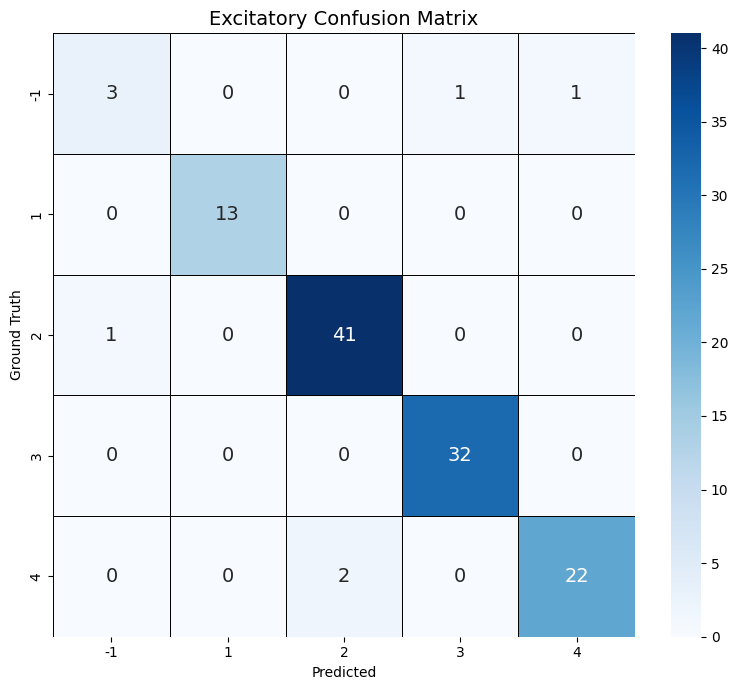

In [110]:
xgboost_plot_confusion_matrix(y_test_clean_as, y_pred_as, title="Excitatory Confusion Matrix")

Saving the model into file

In [111]:
joblib.dump({
    "model": as_xgboost_result["model"],
    "scaler": as_data["scaler_as"],   
    "label_encoder": as_xgboost_result["label_encoder"],
    "ocsvm": as_xgboost_result["ocsvm"]
}, "as_xgb_bundle.pkl")


['as_xgb_bundle.pkl']

#### IV.1.5.2 **Inhibitory ('ss') synapses**

In [112]:
ss_train = df_neuron_cluster[df_neuron_cluster['clusterid'] == 'ss']

In [113]:
ss_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117 entries, 631 to 747
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SynId       117 non-null    int64  
 1   NeuronType  117 non-null    object 
 2   NeuronId    117 non-null    object 
 3   SynType     117 non-null    object 
 4   UMAP_1      117 non-null    float64
 5   UMAP_2      117 non-null    float64
 6   Cluster     117 non-null    int64  
 7   clusterid   117 non-null    object 
dtypes: float64(2), int64(2), object(4)
memory usage: 8.2+ KB


**K-Nearest Neighbors (KNN)**

In [114]:
ss_data = split_umap_data(ss_train)
y_test_ss = ss_data['y_ss_test']
ss_knn_result = knn_with_outlier_filtering(ss_data, label='ss', nu=0.02, k_range=(1, 10, 2), cv=3)

Optimal K: 1, Metric: euclidean

Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           1       1.00      0.80      0.89         5
           2       1.00      0.89      0.94        19

    accuracy                           0.88        24
   macro avg       0.67      0.56      0.61        24
weighted avg       1.00      0.88      0.93        24

Accuracy: 0.875
Macro F1: 0.6111


**Random Forest**

In [115]:
ss_rf_result = random_forest_with_outlier_filtering(
    data_dict=ss_data,
    label='ss',
    nu=0.05,              
    n_estimators=200,     
    max_depth=6           
)


Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           1       1.00      0.80      0.89         5
           2       1.00      0.89      0.94        19

    accuracy                           0.88        24
   macro avg       0.67      0.56      0.61        24
weighted avg       1.00      0.88      0.93        24

Accuracy: 0.875
Macro F1: 0.6111


**XGBoost**

In [116]:
ss_xgboost_result = xgboost_with_outlier_filtering(
    data_dict=ss_data,
    label='ss',
    nu=0.05,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

y_pred_ss = ss_xgboost_result["y_pred"]
y_test_clean_ss = ss_xgboost_result["y_test_clean"]


XGBoost + OneClassSVM results (only Inliers):
Accuracy: 1.0000
Macro F1: 1.0000
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00        18

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23



XGBoost performed best; therefore, its results were displayed in a confusion matrix.

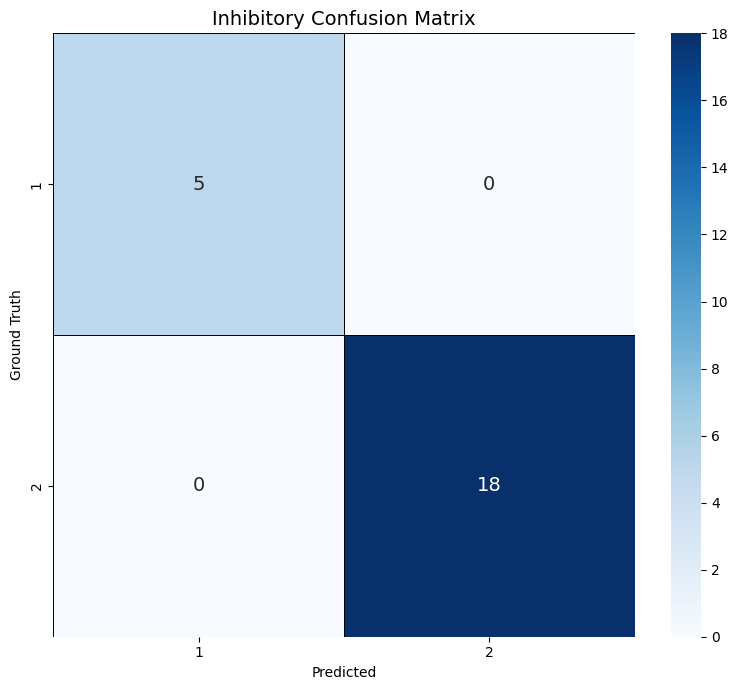

In [117]:
xgboost_plot_confusion_matrix(y_test_clean_ss, y_pred_ss, title="Inhibitory Confusion Matrix")

Saving the model into file

In [118]:
joblib.dump({
    "model": ss_xgboost_result["model"],
    "scaler": ss_data["scaler_ss"],   
    "label_encoder": ss_xgboost_result["label_encoder"],
    "ocsvm": ss_xgboost_result["ocsvm"]
}, "ss_xgb_bundle.pkl")

['ss_xgb_bundle.pkl']

#### IV.1.5.3 **Calbindin ('cb') synapses**

In [119]:
cb_train = df_neuron_cluster[df_neuron_cluster['clusterid'] == 'cb']

In [120]:
cb_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142 entries, 748 to 889
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SynId       142 non-null    int64  
 1   NeuronType  142 non-null    object 
 2   NeuronId    142 non-null    object 
 3   SynType     142 non-null    object 
 4   UMAP_1      142 non-null    float64
 5   UMAP_2      142 non-null    float64
 6   Cluster     142 non-null    int64  
 7   clusterid   142 non-null    object 
dtypes: float64(2), int64(2), object(4)
memory usage: 10.0+ KB


**K-Nearest Neighbors (KNN)**

In [121]:
cb_data = split_umap_data(cb_train)
y_test_cb = cb_data['y_cb_test']
cb_knn_result = knn_with_outlier_filtering(cb_data, label='cb', nu=0.01, k_range=(1, 15, 2), cv=5)

Optimal K: 1, Metric: euclidean

Classification Report:
              precision    recall  f1-score   support

          -1       0.50      0.33      0.40         3
           1       0.92      1.00      0.96        11
           2       1.00      1.00      1.00         5
           3       0.75      0.75      0.75         4
           4       0.83      0.83      0.83         6

    accuracy                           0.86        29
   macro avg       0.80      0.78      0.79        29
weighted avg       0.85      0.86      0.85        29

Accuracy: 0.8621
Macro F1: 0.788


**Random Forest**

In [122]:
cb_rf_result = random_forest_with_outlier_filtering(
    data_dict=cb_data,
    label='cb',     
    nu=0.05,                
    n_estimators=200,       
    max_depth=8             
)


Classification Report:
              precision    recall  f1-score   support

          -1       1.00      0.33      0.50         3
           1       0.85      1.00      0.92        11
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         6

    accuracy                           0.93        29
   macro avg       0.97      0.87      0.88        29
weighted avg       0.94      0.93      0.92        29

Accuracy: 0.931
Macro F1: 0.8833


**XGBoost**

In [123]:
cb_xgboost_result = xgboost_with_outlier_filtering(
    data_dict=cb_data,
    label='cb',
    nu=0.05,
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42
)

y_pred_cb = cb_xgboost_result["y_pred"]
y_test_clean_cb = cb_xgboost_result["y_test_clean"]


XGBoost + OneClassSVM results (only Inliers):
Accuracy: 0.9310
Macro F1: 0.9073
              precision    recall  f1-score   support

          -1       1.00      0.67      0.80         3
           1       0.92      1.00      0.96        11
           2       1.00      1.00      1.00         5
           3       1.00      0.75      0.86         4
           4       0.86      1.00      0.92         6

    accuracy                           0.93        29
   macro avg       0.95      0.88      0.91        29
weighted avg       0.94      0.93      0.93        29



XGBoost performed best; therefore, its results were displayed in a confusion matrix.

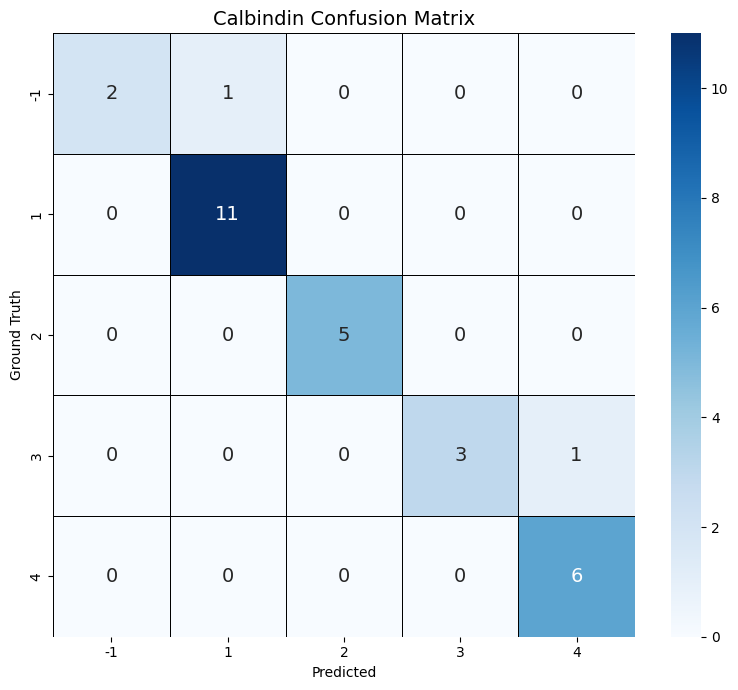

In [124]:
xgboost_plot_confusion_matrix(y_test_clean_cb, y_pred_cb, title="Calbindin Confusion Matrix")

Saving model into file

In [125]:
joblib.dump({
    "model": cb_xgboost_result["model"],
    "scaler": cb_data["scaler_cb"],   
    "label_encoder": cb_xgboost_result["label_encoder"],
    "ocsvm": cb_xgboost_result["ocsvm"]
}, "cb_xgb_bundle.pkl")

['cb_xgb_bundle.pkl']

#### IV.1.5.4 **Calretinin ('cr') synapses**

In [126]:
cr_train = df_neuron_cluster[df_neuron_cluster['clusterid'] == 'cr']

In [127]:
cr_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119 entries, 890 to 1008
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SynId       119 non-null    int64  
 1   NeuronType  119 non-null    object 
 2   NeuronId    119 non-null    object 
 3   SynType     119 non-null    object 
 4   UMAP_1      119 non-null    float64
 5   UMAP_2      119 non-null    float64
 6   Cluster     119 non-null    int64  
 7   clusterid   119 non-null    object 
dtypes: float64(2), int64(2), object(4)
memory usage: 8.4+ KB


**K-Nearest Neighbors (KNN)**

Optimal K: 1, Metric: euclidean

Classification Report:
              precision    recall  f1-score   support

          -1       0.50      1.00      0.67         2
           1       1.00      0.67      0.80         3
           2       1.00      1.00      1.00         5
           3       1.00      0.50      0.67         2
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         6

    accuracy                           0.92        24
   macro avg       0.92      0.86      0.86        24
weighted avg       0.96      0.92      0.92        24

Accuracy: 0.9167
Macro F1: 0.8556


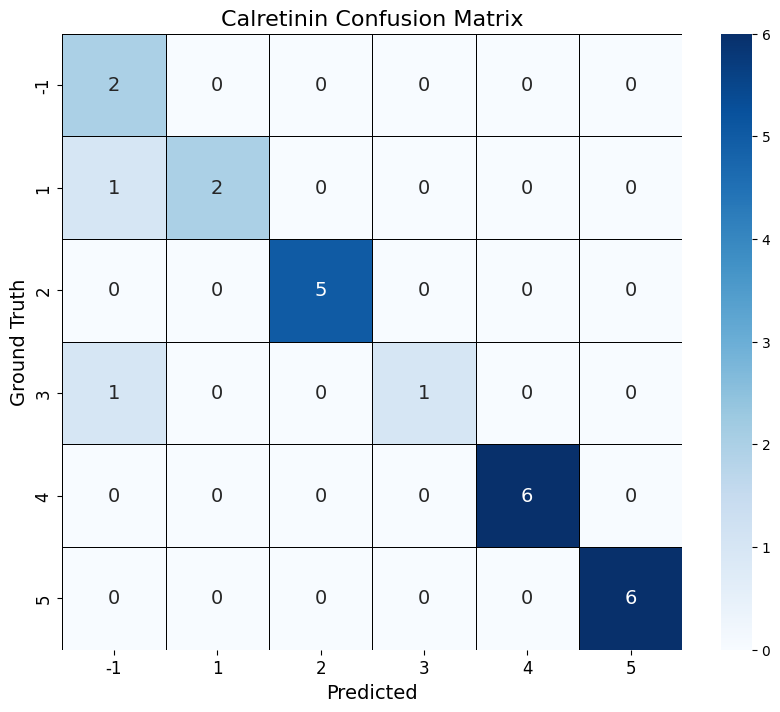

In [128]:
cr_data = split_umap_data(cr_train)
y_test_cr = cr_data['y_cr_test']

cr_knn_result = knn_with_outlier_filtering(cr_data, label='cr', nu=0.005, k_range=(1, 15, 2), cv=5)

y_pred_cr = cr_knn_result["y_pred"]

plot_confusion_matrix(y_test_cr, y_pred_cr, title="Calretinin Confusion Matrix")

KNN achieved the best performance; therefore, its results are presented using a confusion matrix.

Saving model into file

In [129]:
joblib.dump({
    "model": cr_knn_result["model"],
    "ocsvm": cr_knn_result["ocsvm"]
}, "cr_knn_bundle.pkl")

['cr_knn_bundle.pkl']

**Random Forest**

In [130]:
cr_rf_result = random_forest_with_outlier_filtering(
    data_dict=cr_data,
    label='cr',
    nu=0.01,               
    n_estimators=50,       
    max_depth=5,           
    random_state=42
)


Classification Report:
              precision    recall  f1-score   support

          -1       0.50      1.00      0.67         2
           1       1.00      0.67      0.80         3
           2       1.00      1.00      1.00         5
           3       1.00      0.50      0.67         2
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         6

    accuracy                           0.92        24
   macro avg       0.92      0.86      0.86        24
weighted avg       0.96      0.92      0.92        24

Accuracy: 0.9167
Macro F1: 0.8556


In [131]:
joblib.dump({
    "model": cr_rf_result["model"],
    "scaler": cr_data["scaler_cr"],
    "ocsvm": cr_rf_result["ocsvm"]
}, "cr_rf_bundle.pkl")

['cr_rf_bundle.pkl']

**XGBoost**

In [132]:
cr_xgboost_result = xgboost_with_outlier_filtering(
    data_dict=cr_data,
    label='cr',
    nu=0.01,
    n_estimators=50,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)


XGBoost + OneClassSVM results (only Inliers):
Accuracy: 0.9167
Macro F1: 0.7872
              precision    recall  f1-score   support

          -1       0.67      1.00      0.80         2
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       0.00      0.00      0.00         2
           4       1.00      1.00      1.00         6
           5       0.86      1.00      0.92         6

    accuracy                           0.92        24
   macro avg       0.75      0.83      0.79        24
weighted avg       0.85      0.92      0.88        24



#### IV.1.5.5 **Parvalbumin ('pv') synapses**

In [133]:
pv_train = df_neuron_cluster[df_neuron_cluster['clusterid'] == 'pv']

In [134]:
pv_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 487 entries, 1009 to 1495
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SynId       487 non-null    int64  
 1   NeuronType  487 non-null    object 
 2   NeuronId    487 non-null    object 
 3   SynType     487 non-null    object 
 4   UMAP_1      487 non-null    float64
 5   UMAP_2      487 non-null    float64
 6   Cluster     487 non-null    int64  
 7   clusterid   487 non-null    object 
dtypes: float64(2), int64(2), object(4)
memory usage: 34.2+ KB


**K-Nearest Neighbors (KNN)**

In [135]:
pv_data = split_umap_data(pv_train)
y_test_pv = pv_data['y_pv_test']
pv_knn_result = knn_with_outlier_filtering(pv_data, label='pv', nu=0.02, k_range=(1, 25, 2), cv=5)

Optimal K: 1, Metric: euclidean

Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           1       1.00      0.88      0.94        17
           2       1.00      0.99      0.99        81

    accuracy                           0.97        98
   macro avg       0.67      0.62      0.64        98
weighted avg       1.00      0.97      0.98        98

Accuracy: 0.9694
Macro F1: 0.6438


**Random Forest**

In [136]:
pv_rf_result = random_forest_with_outlier_filtering(
    data_dict=pv_data,            
    label='pv',              
    nu=0.1,                   
    n_estimators=100,         
    max_depth=8,              
    random_state=42
)


Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           1       1.00      0.76      0.87        17
           2       1.00      0.98      0.99        81

    accuracy                           0.94        98
   macro avg       0.67      0.58      0.62        98
weighted avg       1.00      0.94      0.97        98

Accuracy: 0.9388
Macro F1: 0.6181


**XGBoost**

In [137]:
pv_xgboost_result = xgboost_with_outlier_filtering(
    data_dict=pv_data,
    label='pv',
    nu=0.1,
    n_estimators=100,
    max_depth=8,
    learning_rate=0.1,
    random_state=42
)

y_pred_pv = pv_xgboost_result["y_pred"]
y_test_clean_pv = pv_xgboost_result["y_test_clean"]


XGBoost + OneClassSVM results (only Inliers):
Accuracy: 1.0000
Macro F1: 1.0000
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        78

    accuracy                           1.00        91
   macro avg       1.00      1.00      1.00        91
weighted avg       1.00      1.00      1.00        91



XGBoost performed best; therefore, its results were displayed in a confusion matrix.

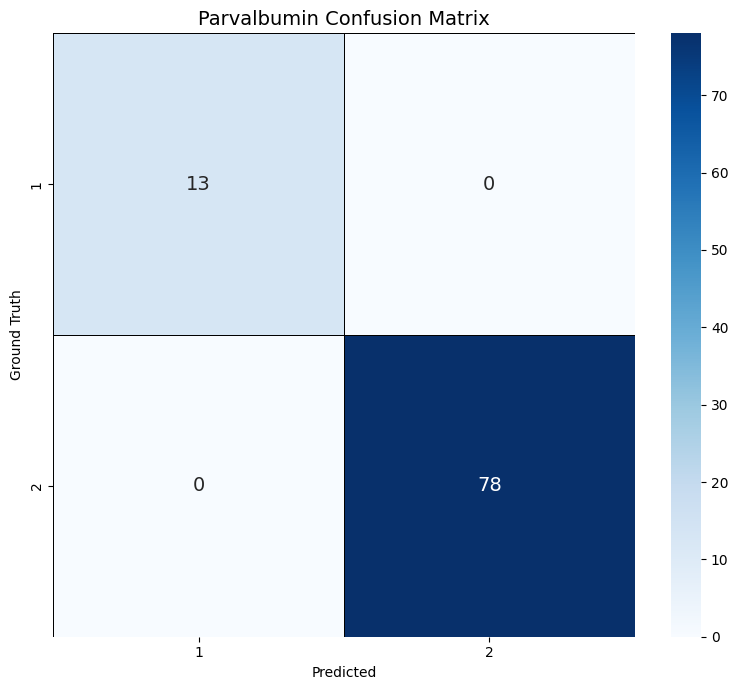

In [138]:
xgboost_plot_confusion_matrix(y_test_clean_pv, y_pred_pv, title="Parvalbumin Confusion Matrix")

In [139]:
joblib.dump({
    "model": pv_xgboost_result["model"],
    "scaler": pv_data["scaler_pv"],   
    "label_encoder": pv_xgboost_result["label_encoder"],
    "ocsvm": pv_xgboost_result["ocsvm"]
}, "pv_xgb_bundle.pkl")

['pv_xgb_bundle.pkl']

#### IV.1.5.5 **Final training performance**

| Metric         | as (excitatory) | ss (inhibitory) | calbindin | calretinin | parvalbumin |
|----------------|----------------|-----------------|-----------|------------|-------------|
| Data count     | 643            | 121             | 149       | 119        | 496         |
| Noise count    | 27             | 0               | 13        | 12         | 0           |
| UMAP component | 2              | 2               | 2         | 2          | 2           |
| Model          | XGBoost        | XGBoost         | XGBoost   | KNN        | XGBoost     |
| Accuracy       | 0.9596         | 1               | 0.9310    | 0.9167     | 1           |
| Macro F1       | 0.9104         | 1               | 0.9073    | 0.8556     | 1           |
| Performance    | STRONG         | STRONG          | STRONG    | STRONG     | STRONG      |